<a href="https://colab.research.google.com/github/gonzalosil/PNL/blob/main/clase_3/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Datos
Utilizare como dataset el tercer libro de la saga Harry Potter

In [2]:
import os
dataset_path = '03 Harry Potter and the Prisoner of Azkaban.txt'
if not os.path.exists(dataset_path):

  !wget https://raw.githubusercontent.com/gonzalosil/PNL/main/clase_2/HP_books/03%20Harry%20Potter%20and%20the%20Prisoner%20of%20Azkaban.txt


In [3]:
with open(dataset_path, 'r') as f:
  text = f.read()

print(len(text))
print(text[:1000])

625735
Harry Potter was a highly unusual boy in many ways. For one thing, he hated the summer holidays more than any other time of year. For another, he really wanted to do his homework, but was forced to do it in secret, in the dead of night. And he also happened to be a wizard.

It was nearly midnight, and he was lying on his front in bed, the blankets drawn right over his head like a tent, a torch in one hand and a large leather-bound book (A History of Magic, by Adalbert Waffling) propped open against the pillow. Harry moved the tip of his eagle-feather quill down the page, frowning as he looked for something that would help him write his essay, ‘Witch-Burning in the Fourteenth Century Was Completely Pointless – discuss’.

The quill paused at the top of a likely-looking paragraph. Harry pushed his round glasses up his nose, moved his torch closer to the book and read:



Non-magic people (more commonly known as Muggles) were particularly afraid of magic in medieval times, but not v

### Elegir el tamaño del contexto
Para este ejercicio seleccionaremos un tamaño fijo de contexto de 5 palabras.

In [4]:
max_context_size = 100

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras

from tensorflow.keras.utils import pad_sequences # se utilizará para padding

# en este caso el vocabulario es el conjunto único de caracteres que existe en tod el texto
chars_vocab = set(text)

# la longitud de vocabulario de caracteres es:
print(len(chars_vocab))

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}


75


###  Tokenizar

In [5]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in text]
tokenized_text[:25]

[22,
 14,
 60,
 60,
 46,
 39,
 20,
 24,
 63,
 63,
 52,
 60,
 39,
 68,
 14,
 69,
 39,
 14,
 39,
 53,
 13,
 26,
 53,
 2,
 46]

### Organizando y estructurando el dataset

In [6]:
import numpy as np

# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [7]:
print(len(tokenized_sentences_val))
print(len(tokenized_sentences_val[0]))

626
0


Nótese que estamos estructurando el problema de aprendizaje como many-to-many:

Entrada: secuencia de tokens $[x_0,x_1, ..., x_n]$

Target: secuencia de tokens $[x_1,x_2, ...,x_{n+1}]$

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como many-to-one en donde sólo una señal de gradiente se propaga.

In [10]:
X.shape

(563035, 100)

In [11]:
X[0,:10]

array([22, 14, 60, 60, 46, 39, 20, 24, 63, 63])

In [12]:
y[0,:10]

array([14, 60, 60, 46, 39, 20, 24, 63, 63, 52])

In [13]:
vocab_size = len(chars_vocab)
vocab_size

75

## Definiendo el modelo
Usaremos una red neuronal simple con embedding, RNN y una capa final linear.

In [14]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas CategoryEncoding que transforma a índices a vectores OHE y TimeDistributed que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [15]:
model = Sequential()
model.add(Input(shape=(None, 1)))
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")))

model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 75)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          55,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 75)            │          15,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,275 (274.51 KB)

 Trainable params: 70,275 (274.51 KB)

 Non-trainable params: 0 (0.00 B)

### Definir modelo

In [16]:
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences

class PplCallback(Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, max_context_size, batch_size=512, patience=5):
        # El callback lo inicializamos con secuencias de validación sobre las cuales
        # mediremos la perplejidad
        self.val_data = val_data
        self.history_ppl = history_ppl
        self.max_context_size = max_context_size
        self.batch_size = batch_size
        self.patience = patience

        self.min_score = np.inf
        self.patience_counter = 0

        self.X = []
        self.y = []

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:
            len_seq = len(seq)

            # armamos todas las subsecuencias
            for i in range(1, len_seq):
                subseq = seq[:i]
                self.X.append(subseq)
                self.y.append(seq[i])

        # rellenamos todas las subsecuencias a la izquierda (padding)
        self.X = pad_sequences(self.X, maxlen=self.max_context_size, padding='pre')
        self.y = np.array(self.y)

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad promedio por batch
        scores = []

        # predecimos por lotes para evitar problemas de memoria
        for i in range(0, len(self.X), self.batch_size):
            x_batch = self.X[i:i+self.batch_size]
            y_batch = self.y[i:i+self.batch_size]

            predictions = self.model.predict(x_batch, verbose=0)

            # en `probs` iremos guardando las probabilidades de los términos target
            probs = predictions[np.arange(len(y_batch)), -1, y_batch]

            # calculamos la perplejidad por medio de logaritmos
            log_probs = np.log(probs + 1e-10)  # evitamos log(0)
            perplexity = np.exp(-np.mean(log_probs))

            scores.append(perplexity)

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save("my_model.keras")
            print("Saved new model!")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter == self.patience:
                print("Stopping training...")
                self.model.stop_training = True


Para calcular la perplejidad sobre el conjunto de validación, se implementó un callback personalizado. La primera versión realizaba predicciones sobre todo el conjunto de validación a la vez, lo que generaba un alto consumo de memoria. Para solucionar esto, se optimizó el callback dividiendo el conjunto de validación en lotes (batch_size) y procesando cada lote por separado, reduciendo significativamente el uso de memoria, ya que previamente se llenaba la memoria de colab

In [14]:
# from tensorflow import keras

# class PplCallback(keras.callbacks.Callback):

#     '''
#     Este callback es una solución ad-hoc para calcular al final de cada epoch de
#     entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
#     La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
#     Además implementa la finalización del entrenamiento (Early Stopping)
#     si la perplejidad no mejora después de `patience` epochs.
#     '''

#     def __init__(self, val_data, history_ppl,patience=5):
#       # El callback lo inicializamos con secuencias de validación sobre las cuales
#       # mediremos la perplejidad
#       self.val_data = val_data

#       self.target = []
#       self.padded = []

#       count = 0
#       self.info = []
#       self.min_score = np.inf
#       self.patience_counter = 0
#       self.patience = patience

#       # nos movemos en todas las secuencias de los datos de validación
#       for seq in self.val_data:

#         len_seq = len(seq)
#         # armamos todas las subsecuencias
#         subseq = [seq[:i] for i in range(1,len_seq)]
#         self.target.extend([seq[i] for i in range(1,len_seq)])

#         if len(subseq)!=0:

#           self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

#           self.info.append((count,count+len_seq))
#           count += len_seq

#       self.padded = np.vstack(self.padded)


#     def on_epoch_end(self, epoch, logs=None):

#         # en `scores` iremos guardando la perplejidad de cada secuencia
#         scores = []

#         predictions = self.model.predict(self.padded,verbose=0)

#         # para cada secuencia de validación
#         for start,end in self.info:

#           # en `probs` iremos guardando las probabilidades de los términos target
#           probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

#           # calculamos la perplejidad por medio de logaritmos
#           scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

#         # promediamos todos los scores e imprimimos el valor promedio
#         current_score = np.mean(scores)
#         history_ppl.append(current_score)
#         print(f'\n mean perplexity: {current_score} \n')

#         # chequeamos si tenemos que detener el entrenamiento
#         if current_score < self.min_score:
#           self.min_score = current_score
#           self.model.save("my_model.keras")
#           print("Saved new model!")
#           self.patience_counter = 0
#         else:
#           self.patience_counter += 1
#           if self.patience_counter == self.patience:
#             print("Stopping training...")
#             self.model.stop_training = True

### Entrenamiento


### Definir el modelo

In [15]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl, max_context_size=max_context_size)], batch_size=256)

Epoch 1/20
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3902
 mean perplexity: 5.233357906341553 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 115s 48ms/step - loss: 2.3901
Epoch 2/20
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8354
 mean perplexity: 4.571587562561035 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 127s 43ms/step - loss: 1.8354
Epoch 3/20
2198/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7455
 mean perplexity: 4.334033966064453 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 143s 44ms/step - loss: 1.7455
Epoch 4/20
2197/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7078
 mean perplexity: 4.263725757598877 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 140s 43ms/step - loss: 1.7078
Epoch 5/20
2199/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6858
 mean perplexity: 4.137736797332764 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 142s 43ms/step - loss: 1.6858
Epoch 6/20
2198/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6710


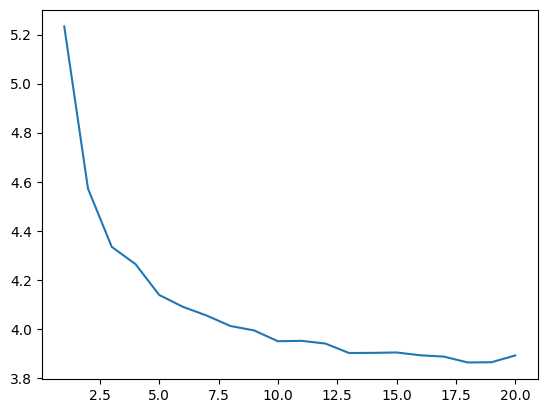

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [17]:
from tensorflow import keras
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

### Prediccion del proximo caracter

In [18]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.2 MB/s eta 0:00:00


In [19]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e3727ac4c5ae666303.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e3727ac4c5ae666303.gradio.live


### Generacion de secuencias

In [20]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text


In [21]:
input_text='Hermi'

generate_seq(model, input_text, max_length=max_context_size, n_words=20)

'Hermione was started to t'

### Beam search y muestreo aleatorio


In [22]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [23]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [24]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=35,input="Harry Potter")

In [25]:
salidas[0]

array([ 8, 35, 68, 68, 30, 63, 69,  9, 62, 62, 40, 68, 11, 28, 63, 73, 35,
       41,  6, 63, 69, 68,  9, 45, 40, 73, 73,  9, 68, 63, 15, 64, 38,  9,
       14, 35,  4, 35, 53, 53, 11, 63, 35, 14,  6, 63, 62])

In [26]:
# veamos las salidas
decode(salidas[0])

'Harry Potter,’ said Professor McGonagall, and t'

### Comparación de arquitecturas recurrentes: SimpleRNN vs LSTM vs GRU


Entrenando modelo: SimpleRNN
Epoch 1/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3971
 mean perplexity: 5.250496864318848 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 113s 48ms/step - loss: 2.3970
Epoch 2/10
2198/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8382
 mean perplexity: 4.567111968994141 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 96s 43ms/step - loss: 1.8381
Epoch 3/10
2198/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7475
 mean perplexity: 4.33168363571167 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 95s 43ms/step - loss: 1.7475
Epoch 4/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7090
 mean perplexity: 4.215415000915527 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 142s 43ms/step - loss: 1.7090
Epoch 5/10
2197/2200 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6868
 mean perplexity: 4.146749973297119 

Saved new model!
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 95s 43ms/step - loss: 1.6868
Epoch 6/10
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 0s

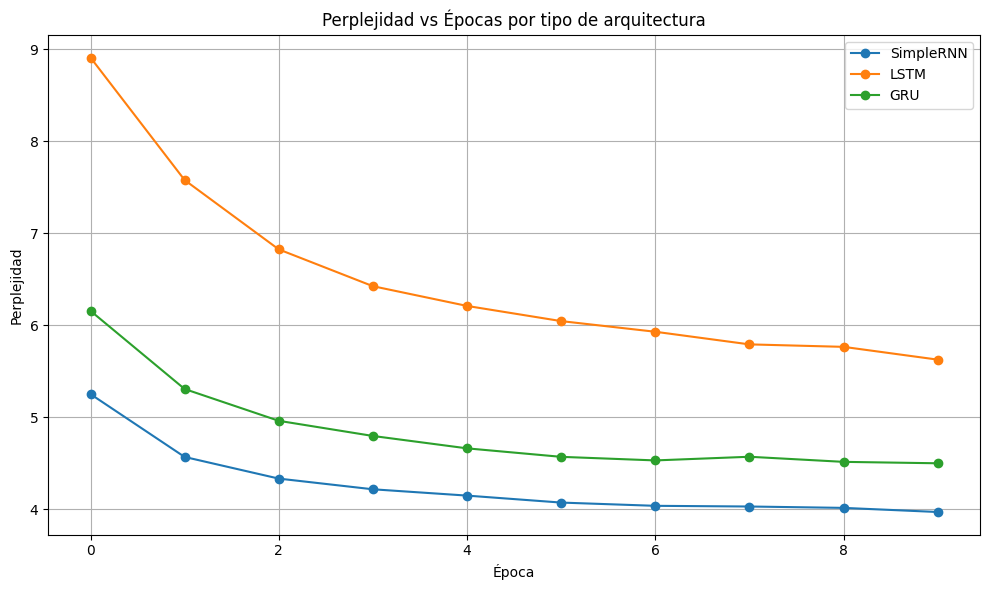

In [17]:
from keras.models import Sequential
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, LSTM, GRU, Dense
import matplotlib.pyplot as plt

# Configuración de hiperparámetros equivalentes
model_configs = {
    "SimpleRNN": {"layer": SimpleRNN, "params": {"units": 200, "recurrent_dropout": 0.1}},
    "LSTM": {"layer": LSTM, "params": {"units": 92, "recurrent_dropout": 0.0}},
    "GRU": {"layer": GRU, "params": {"units": 109, "recurrent_dropout": 0.0}},
}

history_all = {}

# Entrenamiento de los tres modelos
for name, config in model_configs.items():
    print(f"\nEntrenando modelo: {name}")
    model = Sequential()
    model.add(Input(shape=(None, 1)))
    model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")))
    model.add(config["layer"](**config["params"], return_sequences=True, dropout=0.1))
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

    history_ppl = []
    ppl_callback = PplCallback(
        val_data=tokenized_sentences_val,
        history_ppl=history_ppl,
        max_context_size=max_context_size
    )

    model.fit(X, y, epochs=10, batch_size=256, callbacks=[ppl_callback], verbose=1)

    history_all[name] = history_ppl

# Graficar resultados
plt.figure(figsize=(10, 6))
for name, ppl_values in history_all.items():
    plt.plot(ppl_values, label=name, marker='o')

plt.title("Perplejidad vs Épocas por tipo de arquitectura")
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
